In [ ]:
//@version=5
indicator('Market Profile', 'Market Profile', overlay=true, max_bars_back=5000, max_lines_count=500)

// === Input Parameters ===
TimeframeU = input.string(defval='D', title='Higher Time Frame', options=['D'])
percent = input.float(70.0, title='Percent for Value Area %', minval=1, maxval=100) / 100
showpocline = input(true, title='Show POC Line')
offset_bars = input(true, title='Plot Profile From Start of Session (Not End)')
showwhat = input.string(defval='Show All Channels', title='Show Value Area', options=['Don\'t Show Value Area', 'Show Value Area', 'Show All Channels'])
linewdth = input.int(defval=3, title='Line Width', minval=1, maxval=10)
srate = input.float(defval=100., title='Sizing Rate %', minval=10, maxval=500) / 100
poc_col = input(defval=color.new(color.yellow, 0), title='POC Line Color')
vah_col = input(defval=color.new(color.yellow, 50), title='Value Area Color')
nonva_col = input(defval=color.new(color.gray, 50), title='Non-Value Area Color')

// === Configuration ===
rowCount = 50  // Number of TPO rows

// === Variables ===
var float highesthtf = na
var float lowesthtf = na
var float highest = high
var float lowest = low
var int barnum = 0
var int len = 0
bool newbar = ta.change(time(TimeframeU)) != 0

if newbar
    highesthtf := high
    lowesthtf := low
    barnum := 0
else
    highesthtf := math.max(highesthtf, high)
    lowesthtf := math.min(lowesthtf, low)
    barnum += 1

if newbar
    highest := highesthtf[1]
    lowest := lowesthtf[1]
    len := barnum[1]

float channel = (highest - lowest) / rowCount

included(t1, t2, t3, t4) =>
    _ret = t3 >= t1 and t3 <= t2 or t4 >= t1 and t4 <= t2 or t3 <= t1 and t4 >= t2
    _ret

get_tpo(lower, upper) =>
    float ret = 0.
    for x = 1 to len by 1
        if included(lower, upper, low[x], high[x])
            ret += 1
    ret

ch = array.new_float(rowCount + 2, 0.)
if newbar
    for x = 1 to rowCount by 1
        array.set(ch, x, get_tpo(lowest + (x - 1) * channel, lowest + x * channel))

get_index(up, down) =>
    float upval = array.get(ch, up)
    float downval = array.get(ch, down)
    [upval >= downval ? up : down, math.max(upval, downval)]

float total = 0.
int poc_loc = 0
float poc_val = 0.
var int gl_poc_loc = 0
if newbar
    for x = 1 to rowCount by 1
        cval = array.get(ch, x)
        total += cval
        if cval >= poc_val
            poc_val := cval
            poc_loc := x
    gl_poc_loc := poc_loc

float va_val = poc_val
int vahind = poc_loc
int valind = poc_loc
if newbar
    for x = 1 to rowCount by 1
        if va_val >= total * percent
            break
        [ind, chval] = get_index(vahind + 1, valind - 1)
        if chval == 0
            break
        if ind == vahind + 1
            vahind := ind
            va_val += chval
        else
            valind := ind
            va_val += chval

get_middle(x) =>
    float ret = (lowest + (x - 1) * channel + lowest + x * channel) / 2
    ret

get_base(x) =>
    float ret = lowest + (x - 1) * channel
    ret

var int bartime = na
bartime := na(bartime) ? time - time[1] : math.min(bartime, time - time[1])
lastb = ta.valuewhen(newbar, time, 1)

draw_mp(y, chval, is_va) =>
    rchval = math.round(srate * chval)
    linecol = is_va ? vah_col : nonva_col
    offset_line = line.new(x1=time - time + lastb, y1=y, x2=time - time + lastb + bartime * rchval, y2=y, color=linecol, xloc=xloc.bar_time, width=linewdth)
    offset_line

var float midpoc = na
if newbar
    if showpocline
        var line poc_line = na
        midpoc := get_middle(poc_loc)
        poc_line := line.new(x1=time, y1=midpoc, x2=time - time + lastb, y2=midpoc, color=poc_col, xloc=xloc.bar_time, width=1)

    if showwhat == 'Show Value Area' or showwhat == 'Show All Channels'
        var line[] lines = array.new_line(rowCount)
        for i = 0 to rowCount - 1
            array.set(lines, i, na)

        str = showwhat == 'Show All Channels' ? 1 : valind
        end = showwhat == 'Show All Channels' ? rowCount : vahind
        for x = str to end by 1
            is_va = x >= valind and x <= vahind
            chval = array.get(ch, x)
            y = get_base(x)
            l = draw_mp(y, chval, is_va)
            array.set(lines, x - 1, l)

price_in_poc = close >= get_base(gl_poc_loc) and close <= get_base(gl_poc_loc + 1)
price_above_poc = close > get_base(gl_poc_loc + 1)
price_below_poc = close < get_base(gl_poc_loc)

alertcondition(price_in_poc, title='Price in POC', message='Price in POC')
alertcondition((price_in_poc[1] or price_below_poc[1]) and price_above_poc, title='Price went above POC', message='Price went above POC')
alertcondition((price_in_poc[1] or price_above_poc[1]) and price_below_poc, title='Price went below POC', message='Price went below POC')


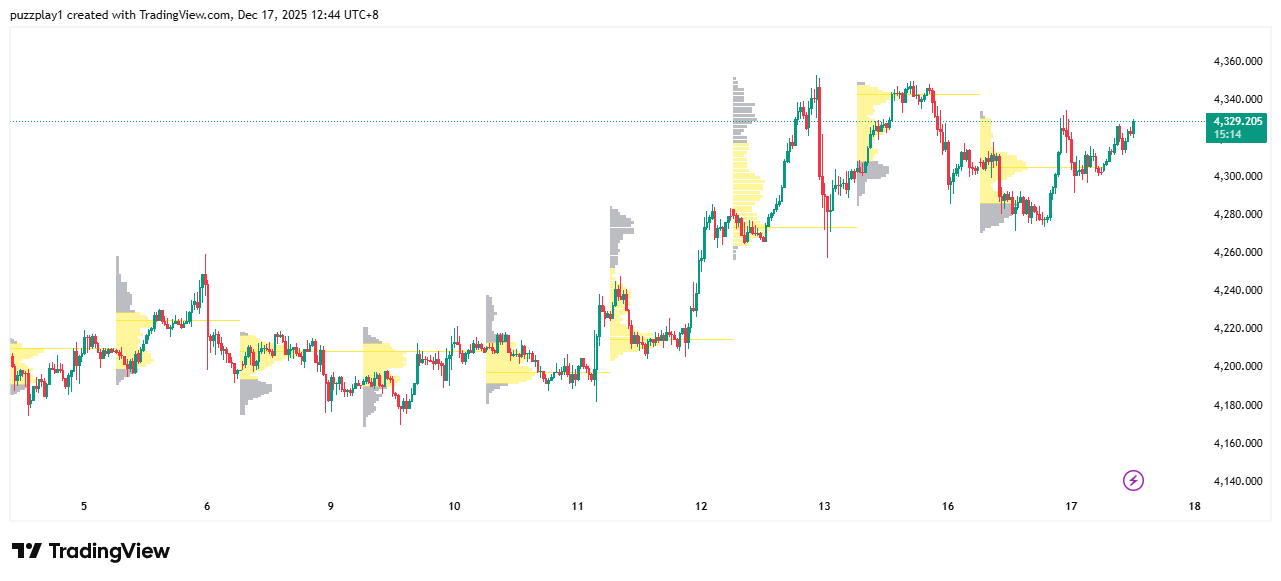